In [1]:
SUBJECT = 1
BASE_DIR = "/tmp/akshett.jindal"
MODEL_ID = "Salesforce/instructblip-vicuna-7b"

In [2]:
MODEL_NAME = MODEL_ID.replace("/", "_").replace(" ", "_")

In [3]:
import os

EXP_DESIGN_FPATH = os.path.join(BASE_DIR, "nsd_expdesign.mat")

In [4]:
OUTPUT_DIR = os.path.join(BASE_DIR, "trained_models", MODEL_NAME)

In [5]:
import glob

IMAGE_EMBEDDINGS_DIR = os.path.join(
    BASE_DIR,
    "image_embeddings",
    MODEL_NAME,
    f"subject_{SUBJECT:02}",
    "batch_*.pkl",
)

batch_paths = sorted(
    glob.glob(IMAGE_EMBEDDINGS_DIR, recursive=True),
    key=lambda i: int(i.split('_')[-1].split('.')[0]),
)

In [6]:
import pickle

VISION_HIDDEN_STATES = {}
QFORMER_HIDDEN_STATES = {}

VISION_LAYERS_COUNT = 0
QFORMER_LAYERS_COUNT = 0

for batch_filepath in batch_paths:

    with open(batch_filepath, "rb") as batch_file:
        batches = pickle.load(batch_file)

    for batch in batches:
        vision_hs = batch['vision_hidden_states']
        qformer_hs = batch['qformer_hidden_states']

        for image_num, image_id in enumerate(batch['image_ids']):
            vhs = tuple(hs[image_num] for hs in vision_hs)
            qhs = tuple(hs[image_num] for hs in qformer_hs)

            VISION_LAYERS_COUNT = len(vhs)
            QFORMER_LAYERS_COUNT = len(qhs)

            VISION_HIDDEN_STATES[image_id] = vhs
            QFORMER_HIDDEN_STATES[image_id] = qhs

    del batches

In [7]:
VISION_LAYERS_COUNT, QFORMER_LAYERS_COUNT

(40, 13)

In [8]:
min(VISION_HIDDEN_STATES.keys()), max(VISION_HIDDEN_STATES.keys())

(14, 73000)

In [10]:
from nsd_dataset import mind_eye_nsd_utils as menutils

(
    trial_order,
    session_data,
    (
        trn_stim_ordering, trn_voxel_data,
        val_stim_ordering, val_voxel_data
    )
) = menutils.get_split_data(BASE_DIR, SUBJECT, average_out_fmri=True)

Total number of voxels = 15724


In [11]:
print(f"{trial_order.shape = }, {trial_order.min() = }, {trial_order.max() = }")
print(f"{session_data.shape = }, {session_data.min() = }, {session_data.max() = }")
print(f"{trn_stim_ordering.shape = }, {trn_stim_ordering.min() = }, {trn_stim_ordering.max() = }")
print(f"{trn_voxel_data.shape = }, {trn_voxel_data.min() = }, {trn_voxel_data.max() = }")
print(f"{val_stim_ordering.shape = }, {val_stim_ordering.min() = }, {val_stim_ordering.max() = }")
print(f"{val_voxel_data.shape = }, {val_voxel_data.min() = }, {val_voxel_data.max() = }")

trial_order.shape = (10000,), trial_order.min() = 1, trial_order.max() = 10000
session_data.shape = (10000, 15724), session_data.min() = -32768.0, session_data.max() = 32767.0
trn_stim_ordering.shape = (9000,), trn_stim_ordering.min() = 1000, trn_stim_ordering.max() = 9999
trn_voxel_data.shape = (9000, 15724), trn_voxel_data.min() = -32768.0, trn_voxel_data.max() = 32767.0
val_stim_ordering.shape = (1000,), val_stim_ordering.min() = 0, val_stim_ordering.max() = 999
val_voxel_data.shape = (1000, 15724), val_voxel_data.min() = -28514.333333333332, val_voxel_data.max() = 32767.0


In [12]:
import numpy as np

np.random.seed(42)

tst_indices = np.random.choice(
    np.arange(trn_stim_ordering.shape[0]),
    size=val_stim_ordering.shape[0],
    replace=False,
)

tst_indices.shape, tst_indices.min(), tst_indices.max()

((1000,), 8, 8999)

In [ ]:
trn_mask = np.ones(trn_stim_ordering.shape[0], dtype=bool)
trn_mask[tst_indices] = False

train_stim_ordering = np.copy(trn_stim_ordering[trn_mask])
train_voxel_data = np.copy(trn_voxel_data[trn_mask])

tst_stim_ordering = np.copy(trn_stim_ordering[tst_indices])
tst_voxel_data = np.copy(trn_voxel_data[tst_indices])

del trn_stim_ordering, trn_voxel_data

trn_stim_ordering = train_stim_ordering
trn_voxel_data = train_voxel_data

In [13]:
print(f"{session_data.shape = }")
print(f"{trn_stim_ordering.shape = }")
print(f"{trn_voxel_data.shape = }")
# print(f"{tst_stim_ordering.shape = }")
# print(f"{tst_voxel_data.shape = }")
print(f"{val_stim_ordering.shape = }")
print(f"{val_voxel_data.shape = }")

session_data.shape = (10000, 15724)
trn_stim_ordering.shape = (9000,)
trn_voxel_data.shape = (9000, 15724)
val_stim_ordering.shape = (1000,)
val_voxel_data.shape = (1000, 15724)


In [14]:
exp_design = menutils.load_exp_design_file(BASE_DIR)

trial_images = exp_design["subjectim"]

In [15]:
trn_images = trial_images[SUBJECT-1, trn_stim_ordering] - 1
val_images = trial_images[SUBJECT-1, val_stim_ordering] - 1
# tst_images = trial_images[SUBJECT-1, tst_stim_ordering] - 1

trn_images.shape, trn_images.min(), trn_images.max()

((9000,), 13, 72999)

In [16]:
import numpy as np
from tqdm.auto import tqdm

### Linear Regresssion

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
VISION_MODELS = []

for layer_num in tqdm(range(VISION_LAYERS_COUNT)):
    trn_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    tst_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in tst_images
    ])

    reg = LinearRegression(copy_X=True).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"[{layer_num+1:02}/{VISION_LAYERS_COUNT:02}] {trn_score = }, {val_score = }, {tst_score = }")

    VISION_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        "tst_score": tst_score,
    })

In [ ]:
import os

VISION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "linear_models", "vision_models")

os.makedirs(VISION_OUTPUT_DIR, exist_ok=True)

for layer_num, vision_model in tqdm(enumerate(VISION_MODELS), total=VISION_LAYERS_COUNT):
    model_path = os.path.join(VISION_OUTPUT_DIR, f"vision_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(vision_model, f)

In [ ]:
QFORMER_MODELS = []

for layer_num in tqdm(range(QFORMER_LAYERS_COUNT)):
    trn_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    tst_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in tst_images
    ])

    reg = LinearRegression(copy_X=True).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"[{layer_num+1:02}/{QFORMER_LAYERS_COUNT:02}] {trn_score = }, {val_score = }, {tst_score = }")

    QFORMER_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        "tst_score": tst_score,
    })

In [ ]:
import os

QFORMER_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "linear_models", "qformer_models")

os.makedirs(QFORMER_OUTPUT_DIR, exist_ok=True)

for layer_num, qformer_model in tqdm(enumerate(QFORMER_MODELS), total=QFORMER_LAYERS_COUNT):
    model_path = os.path.join(QFORMER_OUTPUT_DIR, f"qformer_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(qformer_model, f)

In [ ]:
vision_x = range(1, VISION_LAYERS_COUNT+1)
vision_trn_y = [metric["trn_score"] for metric in VISION_MODELS]
vision_tst_y = [metric["tst_score"] for metric in VISION_MODELS]
vision_val_y = [metric["val_score"] for metric in VISION_MODELS]

qformer_x = range(1, QFORMER_LAYERS_COUNT+1)
qformer_trn_y = [metric["trn_score"] for metric in QFORMER_MODELS]
qformer_tst_y = [metric["tst_score"] for metric in QFORMER_MODELS]
qformer_val_y = [metric["val_score"] for metric in QFORMER_MODELS]

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(vision_x, vision_trn_y, label="Training Dataset")
plt.plot(vision_x, vision_val_y, label="Validation Dataset")
plt.plot(vision_x, vision_tst_y, label="Testing Dataset")
plt.title("Vision Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, f"visual_models_{MODEL_NAME}_linear.png"))
plt.show()
plt.close()

plt.figure()
plt.plot(qformer_x[1:], qformer_trn_y[1:], label="Training Dataset")
plt.plot(qformer_x[1:], qformer_val_y[1:], label="Validation Dataset")
plt.plot(qformer_x[1:], qformer_tst_y[1:], label="Testing Dataset")
plt.title("QFormer Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, f"qformer_models_{MODEL_NAME}_linear.png"))
plt.show()
plt.close()

### Ridge Regresssion

In [31]:
from sklearn.linear_model import Ridge

RIDGE_ALPHA = 1000

In [32]:
VISION_MODELS = []

for layer_num in tqdm(range(VISION_LAYERS_COUNT)):
    trn_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        VISION_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    # tst_hs = np.array([
    #     VISION_HIDDEN_STATES[image_id+1][layer_num]
    #     for image_id in tst_images
    # ])

    reg = Ridge(alpha=RIDGE_ALPHA).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    # tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"[{layer_num+1:02}/{VISION_LAYERS_COUNT:02}] {trn_score = }, {val_score = }")
    # print(f"[{layer_num+1:02}/{VISION_LAYERS_COUNT:02}] {trn_score = }, {val_score = }, {tst_score = }")

    VISION_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        # "tst_score": tst_score,
    })

  0%|          | 0/40 [00:00<?, ?it/s]

[01/40] trn_score = 0.014055900959250004, val_score = 0.010154971424756548
[02/40] trn_score = 0.05678898443872628, val_score = 0.05034108236880723
[03/40] trn_score = 0.07217944755811292, val_score = 0.06553251460116
[04/40] trn_score = 0.08052869656059466, val_score = 0.07198485700150153
[05/40] trn_score = 0.08842811703877702, val_score = 0.07793258846441646
[06/40] trn_score = 0.09685548565078121, val_score = 0.08361010866687045
[07/40] trn_score = 0.11059071620873996, val_score = 0.09485216535510768
[08/40] trn_score = 0.1177649567477515, val_score = 0.09995122075936555
[09/40] trn_score = 0.12377115437276417, val_score = 0.1042274784364142
[10/40] trn_score = 0.1309587118761816, val_score = 0.11123697640082188
[11/40] trn_score = 0.13513477084649408, val_score = 0.11437630792927321
[12/40] trn_score = 0.14066863481327582, val_score = 0.11837313690545839
[13/40] trn_score = 0.14703672140183605, val_score = 0.12307882143773789
[14/40] trn_score = 0.14901411019410474, val_score = 0.

In [33]:
import os

VISION_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "ridge_models", "vision_models")

os.makedirs(VISION_OUTPUT_DIR, exist_ok=True)

for layer_num, vision_model in tqdm(enumerate(VISION_MODELS), total=VISION_LAYERS_COUNT):
    model_path = os.path.join(VISION_OUTPUT_DIR, f"{RIDGE_ALPHA}_vision_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(vision_model, f)

  0%|          | 0/40 [00:00<?, ?it/s]

In [34]:
QFORMER_MODELS = []

for layer_num in tqdm(range(QFORMER_LAYERS_COUNT)):
    trn_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in trn_images
    ])
    val_hs = np.array([
        QFORMER_HIDDEN_STATES[image_id+1][layer_num]
        for image_id in val_images
    ])
    # tst_hs = np.array([
    #     QFORMER_HIDDEN_STATES[image_id+1][layer_num]
    #     for image_id in tst_images
    # ])

    reg = Ridge(alpha=RIDGE_ALPHA).fit(trn_hs, trn_voxel_data)
    # print(f"{reg.coef_ = }, {reg.intercept_ = }")

    # trn_voxel_data_pred = reg.predict(trn_hs)
    # val_voxel_data_pred = reg.predict(val_hs)
    # tst_voxel_data_pred = reg.predict(tst_hs)
    # # print(f"{reg.score(val_hs, val_voxel_data_pred) = }")
    trn_score = reg.score(trn_hs, trn_voxel_data)
    val_score = reg.score(val_hs, val_voxel_data)
    # tst_score = reg.score(tst_hs, tst_voxel_data)

    print(f"[{layer_num+1:02}/{QFORMER_LAYERS_COUNT:02}] {trn_score = }, {val_score = }")
    # print(f"[{layer_num+1:02}/{QFORMER_LAYERS_COUNT:02}] {trn_score = }, {val_score = }, {tst_score = }")

    QFORMER_MODELS.append({
        "model": reg,
        "trn_score": trn_score,
        "val_score": val_score,
        # "tst_score": tst_score,
    })

  0%|          | 0/13 [00:00<?, ?it/s]

[01/13] trn_score = -4.395683723736771e-12, val_score = -0.004602706647313572
[02/13] trn_score = 0.12483125661109859, val_score = 0.11052390266617688
[03/13] trn_score = 0.12497831701525064, val_score = 0.1100728185555176
[04/13] trn_score = 0.1416927225511454, val_score = 0.11882397553246223
[05/13] trn_score = 0.13702755280606393, val_score = 0.11703034578735166
[06/13] trn_score = 0.1443815609556518, val_score = 0.1197615819647138
[07/13] trn_score = 0.13739270434672307, val_score = 0.11775306998078743
[08/13] trn_score = 0.14605762319377286, val_score = 0.12083248977315593
[09/13] trn_score = 0.1404058964547301, val_score = 0.11846674975526639
[10/13] trn_score = 0.14353007681765922, val_score = 0.11823276547643412
[11/13] trn_score = 0.13881964308491407, val_score = 0.11620450146282102
[12/13] trn_score = 0.1373780056060364, val_score = 0.11558204171722734
[13/13] trn_score = 0.13464993325669863, val_score = 0.11433138705987163


In [35]:
import os

QFORMER_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "ridge_models", "qformer_models")

os.makedirs(QFORMER_OUTPUT_DIR, exist_ok=True)

for layer_num, qformer_model in tqdm(enumerate(QFORMER_MODELS), total=QFORMER_LAYERS_COUNT):
    model_path = os.path.join(QFORMER_OUTPUT_DIR, f"{RIDGE_ALPHA}_qformer_model_{layer_num:03}.pkl")

    with open(model_path, "wb") as f:
        pickle.dump(qformer_model, f)

  0%|          | 0/13 [00:00<?, ?it/s]

In [36]:
vision_x = range(1, VISION_LAYERS_COUNT+1)
vision_trn_y = [metric["trn_score"] for metric in VISION_MODELS]
# vision_tst_y = [metric["tst_score"] for metric in VISION_MODELS]
vision_val_y = [metric["val_score"] for metric in VISION_MODELS]

qformer_x = range(1, QFORMER_LAYERS_COUNT+1)
qformer_trn_y = [metric["trn_score"] for metric in QFORMER_MODELS]
# qformer_tst_y = [metric["tst_score"] for metric in QFORMER_MODELS]
qformer_val_y = [metric["val_score"] for metric in QFORMER_MODELS]

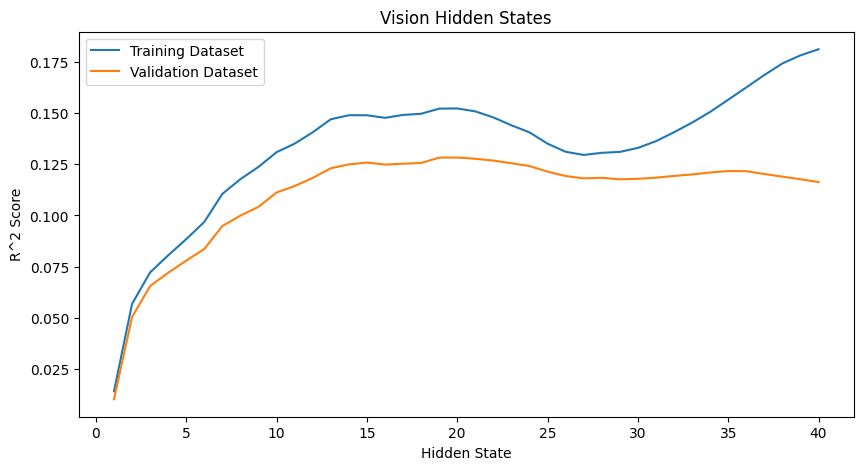

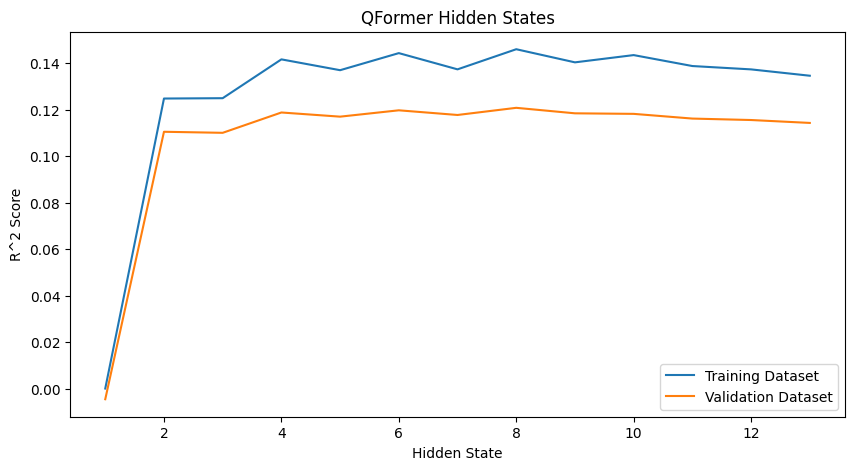

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(vision_x, vision_trn_y, label="Training Dataset")
plt.plot(vision_x, vision_val_y, label="Validation Dataset")
# plt.plot(vision_x, vision_tst_y, label="Testing Dataset")
plt.title("Vision Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, f"visual_models_{MODEL_NAME}_ridge_{RIDGE_ALPHA}.png"))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(qformer_x, qformer_trn_y, label="Training Dataset")
plt.plot(qformer_x, qformer_val_y, label="Validation Dataset")
# plt.plot(qformer_x, qformer_tst_y, label="Testing Dataset")
# plt.plot(qformer_x[1:], qformer_trn_y[1:], label="Training Dataset")
# plt.plot(qformer_x[1:], qformer_val_y[1:], label="Validation Dataset")
# plt.plot(qformer_x[1:], qformer_tst_y[1:], label="Testing Dataset")
plt.title("QFormer Hidden States")
plt.xlabel("Hidden State")
plt.ylabel("R^2 Score")
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, f"qformer_models_{MODEL_NAME}_ridge_{RIDGE_ALPHA}.png"))
plt.show()

In [38]:
for i in range(len(VISION_MODELS)):
    del VISION_MODELS[i]['model']

for i in range(len(QFORMER_MODELS)):
    del QFORMER_MODELS[i]['model']

del VISION_MODELS
del QFORMER_MODELS

### VoxelWise-Tutorials